In [65]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import norm
from scipy.stats import norm, bernoulli

In [332]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

def plot_neural_activity(spikes_over_time, u_over_time, utarg_over_time, dt, n_neurons_to_plot, time_param, nloop):
    stim_on, stim_off, train_duration = time_param
    time_steps_per_period = int(train_duration / dt)
    total_time_steps = spikes_over_time.shape[0]
    time_vector = np.arange(0, total_time_steps * dt, dt)

    # Create figure and specify grid dimensions
    fig = plt.figure(figsize=(40, 4 * n_neurons_to_plot))
    gs = gridspec.GridSpec(2 * n_neurons_to_plot, 1, height_ratios=[1, 3] * n_neurons_to_plot)

    for i in range(n_neurons_to_plot):
        # Raster plot (smaller height)
        ax_raster = fig.add_subplot(gs[2 * i])
        ax_raster.set_title(f'Neuron {i} - Raster Plot')
        spike_times = time_vector[np.where(spikes_over_time[:, i])[0]]
        # Increase the marker size with the `s` parameter
        ax_raster.scatter(spike_times, np.zeros_like(spike_times), marker='|', color='black', s=10)
        ax_raster.set_yticks([])
        ax_raster.set_xlim(0, time_vector[-1])

        # Analog potential plot (greater height)
        ax_activity = fig.add_subplot(gs[2 * i + 1], sharex=ax_raster)
        ax_activity.set_title(f'Neuron {i} - Analog Potential')
        ax_activity.plot(time_vector, u_over_time[:, i], label='Synaptic Drive')
        ax_activity.plot(time_vector, utarg_over_time[:, i], 'r', label='Target')

        # Shade periods of external stimulus
        for loop in range(nloop):
            loop_start = loop * time_steps_per_period * dt
            loop_end = (loop + 1) * time_steps_per_period * dt
            ax_raster.axvspan(max(stim_on + loop_start, loop_start), min(stim_off + loop_start, loop_end), color='orange', alpha=0.3)
            ax_activity.axvspan(max(stim_on + loop_start, loop_start), min(stim_off + loop_start, loop_end), color='orange', alpha=0.3)

        # Set labels and legends
        if i == n_neurons_to_plot - 1:
            ax_activity.set_xlabel('Time (ms)')
        ax_activity.legend(loc='upper right')

        # Hide x-axis labels for raster plot to align with activity plot
        ax_raster.get_xaxis().set_visible(False)

    plt.tight_layout()
    plt.show()


In [66]:
def genw_sparse(N, m, sd, p):
    """
    Generates a sparse weight matrix for a neural network.

    Parameters:
    N (int): Number of neurons.
    m (float): Mean of the normal distribution for the weights.
    sd (float): Standard deviation of the normal distribution for the weights.
    p (float): Probability of having a connection between two neurons.

    Returns:
    numpy.ndarray: A generated sparse weight matrix of size N x N.
    """

    # Ensure N is an integer in case a float is passed
    N = int(N)

    # Initialize an N x N matrix with zeros
    w = np.zeros((N, N))

    # Recurrent connections
    for i in range(N):
        for j in range(N):
            # Generate a random number to decide if there should be a connection
            # based on the probability p (Bernoulli distribution)
            if np.random.rand() < p:
                # If a connection is to be made, assign a weight based on a normal
                # distribution with mean 'm' and standard deviation 'sd'
                w[i, j] = norm.rvs(m, sd)

    # No autapse (neurons do not connect to themselves)
    # Set the diagonal elements of the matrix to 0
    np.fill_diagonal(w, 0)

    # Return the generated weight matrix
    return w

In [67]:
def run_target(M, net_param, target_type):
    """
    Generates target trajectories based on the specified target type.

    Parameters:
    M (numpy.ndarray): The connectivity matrix.
    net_param (list): List containing network parameters [N, p, g, b, dt, T].
    target_type (str): Type of target to generate ('periodic', 'ratemodel', or 'ou').

    Returns:
    numpy.ndarray: Generated target trajectories.
    """

    # Unpacking network parameters
    N, p, g, b, dt, T = net_param
    N = int(N)

    # Create a time vector
    t = np.arange(dt, T + dt, dt)

    # 1. Periodic functions
    if target_type == "periodic":
        # Initialize an array to store the periodic target patterns for each neuron.
        # The array has dimensions equal to the length of time vector 't' and the number of neurons 'N'.
        u_periodic = np.zeros((len(t), N))

        # Loop over each neuron to generate a unique periodic pattern for each.
        for j in range(N):
            # Randomly determine the amplitude 'A' for the pattern of each neuron.
            # It ranges from 0.5 to 1.5.
            A = 0.5 + np.random.rand()

            # Randomly determine two periods 'T1' and 'T2' for the sinusoidal waves.
            # T1 ranges from 50 to 100, and T2 ranges from 10 to 50.
            T1 = 50. + 50. * np.random.rand()
            T2 = 10. + 40. * np.random.rand()

            # Randomly determine phase shifts 't1' and 't2' for the sinusoidal waves.
            # These are based on the periods 'T1' and 'T2'.
            t1 = T1 * np.random.rand()
            t2 = T2 * np.random.rand()

            # Generate periodic target patterns for each neuron.
            # The pattern is a product of two sinusoidal waves with different periods and phase shifts.
            # The waves are scaled by the amplitude 'A'.
            u_periodic[:, j] = A * np.sin((t - t1) * (2 * np.pi / T1)) * np.sin((t - t2) * (2 * np.pi / T2))

        # Return the matrix containing the generated periodic patterns for each neuron.
        return u_periodic

    # 2. Rate network model
    if target_type == "ratemodel":
        u_rm = np.zeros((len(t), N))
        g_rm = 5
        M = g_rm * genw_sparse(N, 0, 1, p) / np.sqrt(N * p)
        b_rm = 1 / 4

        # Adjust the matrix M so the mean of incoming synaptic connections is zero
        for i in range(N):
            idx = np.abs(M[i, :]) > 0
            M[i, idx] -= np.mean(M[i, idx])

        # Random initial condition
        u_rm[0, :] = 0.2 * np.random.rand(N)

        # Non-linear function phi
        def phi(x):
            x[x < 0] = 0
            return np.sqrt(x) / np.pi

        # Generate rate model target patterns
        for i in range(len(t) - 1):
            u_rm[i + 1, :] = (1 - dt * b_rm) * u_rm[i, :] + dt * b_rm * M.dot(phi(u_rm[i, :]))

        return u_rm

    # 3. Ornstein-Uhlenbeck process
    if target_type == "ou":
        u_ou = np.zeros((len(t), N))
        b_ou = 1 / 20
        mu = 0.0
        sig = 0.3

        # Generate OU target patterns
        for j in range(N):
            for i in range(len(t) - 1):
                u_ou[i + 1, j] = u_ou[i, j] + b_ou * (mu - u_ou[i, j]) * dt + sig * np.sqrt(dt) * norm.rvs()

        return u_ou

In [362]:
def run_train(M, net_param, train_param, time_param, dt, utarg):
    """
    Trains a neural network model.

    Parameters:
    M (numpy.ndarray): Initial weight matrix.
    net_param (list): Network parameters [x, r, b].
    train_param (list): Training parameters [stim, lambda, learn_every, nloop, target_type].
    time_param (list): Time parameters [stim_on, stim_off, train_time].
    dt (float): Time step for the simulation.
    utarg (numpy.ndarray): Target trajectories for training.

    Returns:
    numpy.ndarray: Updated weight matrix after training.
    """
    
    N = M.shape[1]
    w = np.zeros((N, N))
    extinput = np.zeros(N)
    u = np.zeros(N)

    # Store the initial weight matrix for normalization
    M_initial = np.copy(M)

    # Unpack network parameters
    x, r, b = net_param

    # Unpack training parameters
    stim, lambda_, learn_every, nloop, target_type = train_param
    
    # Unpack time parameters
    stim_on, stim_off, train_time = time_param

    # Define RHS of ODEs
    def dtheta(x_var, I_var):
        return 1 - np.cos(x_var) + I_var * (1 + np.cos(x_var))

    def dr(r_var):
        return -b * r_var

    # Set up correlation matrix
    P = {}
    Px = {}
    for ni in range(N):
        ni_preind = M[ni, :] != 0
        P[ni] = np.eye(np.sum(ni_preind)) / lambda_
        Px[ni] = ni_preind

    t = 0.
    
    # Calculate the number of time steps for a single training period
    time_steps_per_period = int(train_time / dt)

    # Total time steps for all training iterations
    total_time_steps = time_steps_per_period * nloop

    # Initialize arrays to store spikes, synaptic drive, and target function for all neurons over the entire training iterations
    spikes_over_time = np.zeros((total_time_steps, N), dtype=int)
    u_over_time = np.zeros((total_time_steps, N))
    utarg_over_time = np.zeros((total_time_steps, N))
    
    # Metrics storage
    pearson_correlations = []
    frobenius_norms = []
    
    for iloop in range(int(nloop)):
        print(f"Loop {iloop + 1}...\n")
        loop_start_index = iloop * time_steps_per_period
        
        # Initialize the cumulative MSE for this loop
        cumulative_mse = 0.0
    
        for i in range(int(train_time / dt)):
            
            # Calculate the global index in the total training duration
            global_index = loop_start_index + i
            if global_index >= total_time_steps:
                break
            
            # External stimulus
            if stim_on / dt < i <= stim_off / dt:
                extinput[:] = stim
            else:
                extinput[:] = np.zeros(N)

            # Update neuron phase using RK4 integration
            k1 = dt * dtheta(x, u + extinput)
            k2 = dt * dtheta(x + k1 / 2, u + extinput)
            k3 = dt * dtheta(x + k2 / 2, u + extinput)
            k4 = dt * dtheta(x + k3, u + extinput)
            xnext = x + (k1 + 2 * k2 + 2 * k3 + k4) / 6

            # Update filtered spikes
            l1 = dt * dr(r)
            l2 = dt * dr(r + l1 / 2)
            l3 = dt * dr(r + l2 / 2)
            l4 = dt * dr(r + l3)

            # Spike detection
            idx = (xnext - x > 0) & (xnext - x > np.mod(np.pi - np.mod(x, 2 * np.pi), 2 * np.pi))
            ind = np.where(idx)[0]
            spikes_over_time[i, :] = idx.astype(int)

            # Update each neuron's spike
            if ind.size > 0:
                r[idx] += b

            # Update variables for the next iteration
            x = x + (k1 + 2 * k2 + 2 * k3 + k4) / 6 # Neuron phase
            r = r + (l1 + 2 * l2 + 2 * l3 + l4) / 6 # Firing rate
            u = M @ r # After x and r are updated, u is calculated as the product of the weight matrix M and the firing rate vector r.
            t += dt
            
            # Calculate MSE at this iteration and accumulate it
            mse = np.mean((utarg[i, :] - u) ** 2)
            # Update the cumulative MSE
            cumulative_mse += mse * dt  # Integrate over time by summing and multiplying by dt
            
            # Record spikes, synaptic drive, and target function at each global time step
            spikes_over_time[global_index, :] = idx.astype(int)
            u_over_time[global_index, :] = u
            utarg_over_time[global_index, :] = utarg[i, :]
            
            # Training weight matrix at specified intervals
            if stim_off / dt < i <= train_time / dt and i % (learn_every / dt) == 0:
                for ni in range(N):
                    # Update inverse correlation matrix
                    k = P[ni] @ r[Px[ni]]
                    vPv = r[Px[ni]].T @ k
                    den = 1.0 / (1.0 + vPv)
                    P[ni] -= k[:, None] @ (k[None, :] * den)

                    # Update recurrent weights
                    e = M[ni, Px[ni]] @ r[Px[ni]] - utarg[i, ni]
                    dw = -e * k * den
                    M[ni, Px[ni]] += dw
        
                # Compute the L2 norm of the weight matrix, which is the Frobenius norm for matrices
                norm_W = np.linalg.norm(M, 'fro')

                # Compute the regularization term
                regularization = (lambda_ / 2) * (norm_W ** 2)

                # Compute the total cost for this training loop
                total_cost = (cumulative_mse / 2) + regularization  # The 1/2 factor comes from the definition of the cost function
                
                # Pearson correlation
                correlation = np.corrcoef(u, utarg[i, :])[0, 1]
                pearson_correlations.append(correlation)
                
                # Frobenius norm of weight matrix changes, normalized
                frobenius_norm = np.linalg.norm(M - M_initial, 'fro') / np.linalg.norm(M_initial, 'fro')
                frobenius_norms.append(frobenius_norm)
        

        
        # Print the time-integrated MSE and the total cost for this loop
        print(f"Time-Integrated MSE for Loop {iloop + 1}: {cumulative_mse:.4f}")
        print(f"Regularization Term for Loop {iloop + 1}: {regularization:.4f}")
        print(f"Total Cost for Loop {iloop + 1}: {total_cost:.4f}")
    return M, spikes_over_time, u_over_time, utarg_over_time, pearson_correlations, frobenius_norms

In [187]:
def run_test(M, net_param, time_param, dt):
    """
    Runs a test simulation on the neural network model.

    Parameters:
    M (numpy.ndarray): Weight matrix of the neural network.
    net_param (list): Network parameters [x, r, b, stim].
    time_param (list): Time parameters [stim_on, stim_off, test_time].
    dt (float): Time step for the simulation.

    Returns:
    numpy.ndarray: The test output of the network over time.
    """
    N = M.shape[1]
    extinput = np.zeros(N)
    u = np.zeros(N)

    # Unpack network parameters
    x, r, b, stim = net_param
    
    # Unpack time parameters
    stim_on, stim_off, test_time = time_param

    # Define RHS of ODEs
    def dtheta(x_var, I_var):
        return 1. - np.cos(x_var) + I_var * (1. + np.cos(x_var))

    def dr(r_var):
        return -b * r_var

    t = 0.

    # Initialize array to store test data
    utest = np.zeros((int(test_time / dt), N))

    for i in range(int(test_time / dt)):
        if stim_on / dt < i <= stim_off / dt:
            extinput[:] = stim
        else:
            extinput[:] = np.zeros(N)

        # Define synaptic activity
        u = M @ r

        # Update neuron phase using RK4 integration
        k1 = dt * dtheta(x, u + extinput)
        k2 = dt * dtheta(x + k1 / 2, u + extinput)
        k3 = dt * dtheta(x + k2 / 2, u + extinput)
        k4 = dt * dtheta(x + k3, u + extinput)
        xnext = x + (k1 + 2 * k2 + 2 * k3 + k4) / 6

        # Update filtered spikes
        l1 = dt * dr(r)
        l2 = dt * dr(r + l1 / 2)
        l3 = dt * dr(r + l2 / 2)
        l4 = dt * dr(r + l3)

        # Spike detection
        idx = (xnext - x > 0) & (xnext - x > np.mod(np.pi - np.mod(x, 2 * np.pi), 2 * np.pi))
        ind = np.where(idx)[0]

        # Update each neuron's spikes
        if ind.size > 0:
            r[idx] += b

        # Update x, r
        x = x + (k1 + 2 * k2 + 2 * k3 + k4) / 6
        r = r + (l1 + 2 * l2 + 2 * l3 + l4) / 6
        u = M @ r
        t += dt

        # Save test data
        utest[i, :] = u

    return utest

In [363]:
# Define the size of the network and the connectivity parameters
N = 100  # Number of neurons
p = 0.3  # Probability of having a connection between two neurons
g = 1.0  # Scaling factor for weights

# Neuron dynamics parameter
b = 1/2  # Parameter related to the neuron dynamics, possibly a bias term

# Training parameters
train_duration = 100.0  # Duration of the training phase
nloop = 10  # Number of training loops (can be adjusted)
lambda_ = 0.5  # Regularization parameter (can be adjusted)
learn_every = 1.0  # Frequency of learning updates

# Stimulation parameters
stim_on = 100.0  # Time when the stimulus turns on
stim_off = 110.0  # Time when the stimulus turns off
train_time = stim_off + train_duration  # Total training time
test_time = train_time + 100.0  # Total time for testing phase

# Time step for simulation
dt = 0.1  # Time step in the simulation

In [364]:
# Choose the type of target for the training
target_type = "periodic"  # Target type (e.g., "periodic", "ou", "ratemodel")

# Generate the initial weight matrix (connectivity matrix)
M = genw_sparse(N, 0, 1, p) / np.sqrt(N * p)

# Generate a random stimulus
stim = 2 * (2 * np.random.rand(N) - 1)
#stim = np.zeros(N)

# Set up parameters for the network and generate target patterns
net_param = [N, p, g, b, dt, test_time]
utarg = run_target(M, net_param, target_type)

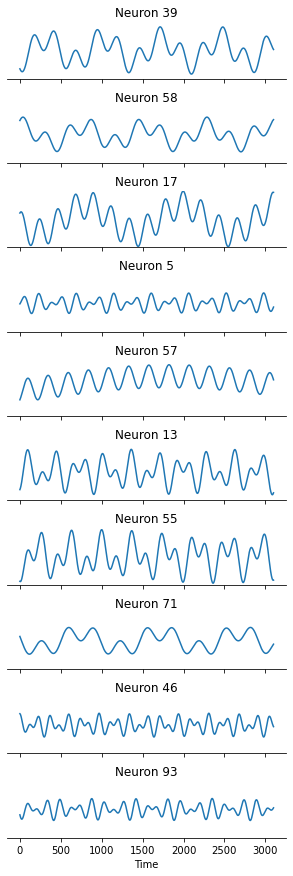

In [365]:
# Select 10 random neurons to visualize
N = utarg.shape[1]  # Number of neurons (columns in utarg)
selected_neurons = np.random.choice(N, 10, replace=False)

# Determine the common y-axis limits
y_min = utarg.min()
y_max = utarg.max()

# Plotting in stacked layout
fig, axes = plt.subplots(10, 1, figsize=(5, 15), sharex=True)

for i, neuron in enumerate(selected_neurons):
    axes[i].plot(utarg[:, neuron])
    axes[i].set_title(f'Neuron {neuron}')
    axes[i].set_ylim([y_min, y_max])  # Set uniform y-axis limits
    axes[i].spines['top'].set_visible(False)  # Remove top border
    axes[i].spines['right'].set_visible(False)  # Remove right border
    axes[i].spines['left'].set_visible(False)  # Remove left border
    axes[i].get_yaxis().set_ticks([])  # Remove y-axis ticks

# Set common labels
plt.xlabel('Time')
plt.subplots_adjust(hspace=0.5)
plt.show()

In [366]:
# Training phase
# Initialize initial conditions for the network
x0 = 2 * np.pi * np.random.rand(N)
r0 = np.zeros(N)

# Set up training parameters
net_param = [x0, r0, b]
train_param = [stim, lambda_, learn_every, nloop, target_type]
time_param = [stim_on, stim_off, train_time]

# Run the training process
M, spikes_over_time, u_over_time, utarg_over_time, pearson_correlations, frobenius_norms = run_train(M, net_param, train_param, time_param, dt, utarg)

Loop 1...

Time-Integrated MSE for Loop 1: 47.0636
Regularization Term for Loop 1: 129.7005
Total Cost for Loop 1: 153.1301
Loop 2...

Time-Integrated MSE for Loop 2: 55.9564
Regularization Term for Loop 2: 123.5880
Total Cost for Loop 2: 151.4302
Loop 3...

Time-Integrated MSE for Loop 3: 54.7823
Regularization Term for Loop 3: 115.5891
Total Cost for Loop 3: 142.8461
Loop 4...

Time-Integrated MSE for Loop 4: 55.7594
Regularization Term for Loop 4: 112.9176
Total Cost for Loop 4: 140.6719
Loop 5...

Time-Integrated MSE for Loop 5: 54.4057
Regularization Term for Loop 5: 112.1074
Total Cost for Loop 5: 139.1624
Loop 6...

Time-Integrated MSE for Loop 6: 56.8146
Regularization Term for Loop 6: 101.0904
Total Cost for Loop 6: 129.3740
Loop 7...

Time-Integrated MSE for Loop 7: 55.8571
Regularization Term for Loop 7: 97.3931
Total Cost for Loop 7: 125.1824
Loop 8...

Time-Integrated MSE for Loop 8: 54.9763
Regularization Term for Loop 8: 92.0989
Total Cost for Loop 8: 119.4474
Loop 9...


In [367]:
def visualize_metrics(pearson_correlations, frobenius_norms):
    plt.figure(figsize=(12, 6))

    # Pearson Correlations
    plt.subplot(2, 1, 1)
    plt.plot(pearson_correlations, label='Pearson Correlation')
    plt.title('Pearson Correlation Over Training')
    plt.ylabel('Correlation')
    plt.xlabel('Training Steps')
    plt.legend()

    # Frobenius Norms
    plt.subplot(2, 1, 2)
    plt.plot(frobenius_norms, label='Frobenius Norm of Changes in M')
    plt.title('Normalized Frobenius Norm Over Training')
    plt.ylabel('Normalized Frobenius Norm')
    plt.xlabel('Training Steps')
    plt.legend()

    plt.tight_layout()
    plt.show()

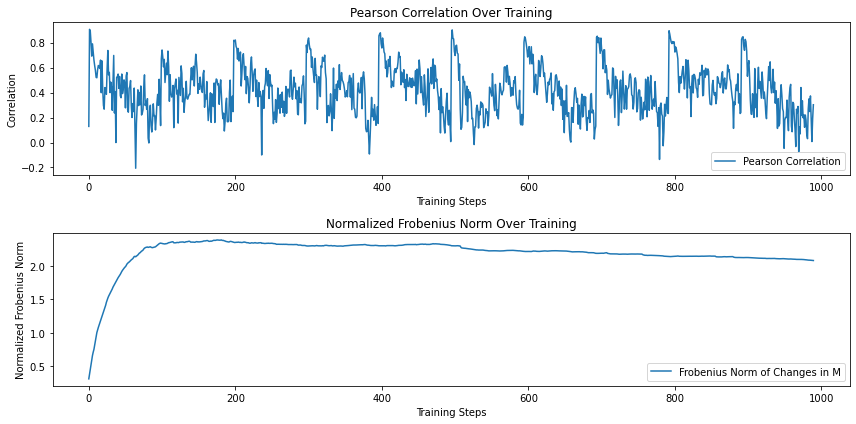

In [368]:
visualize_metrics(pearson_correlations, frobenius_norms)

In [369]:
neurons_to_plot = 5

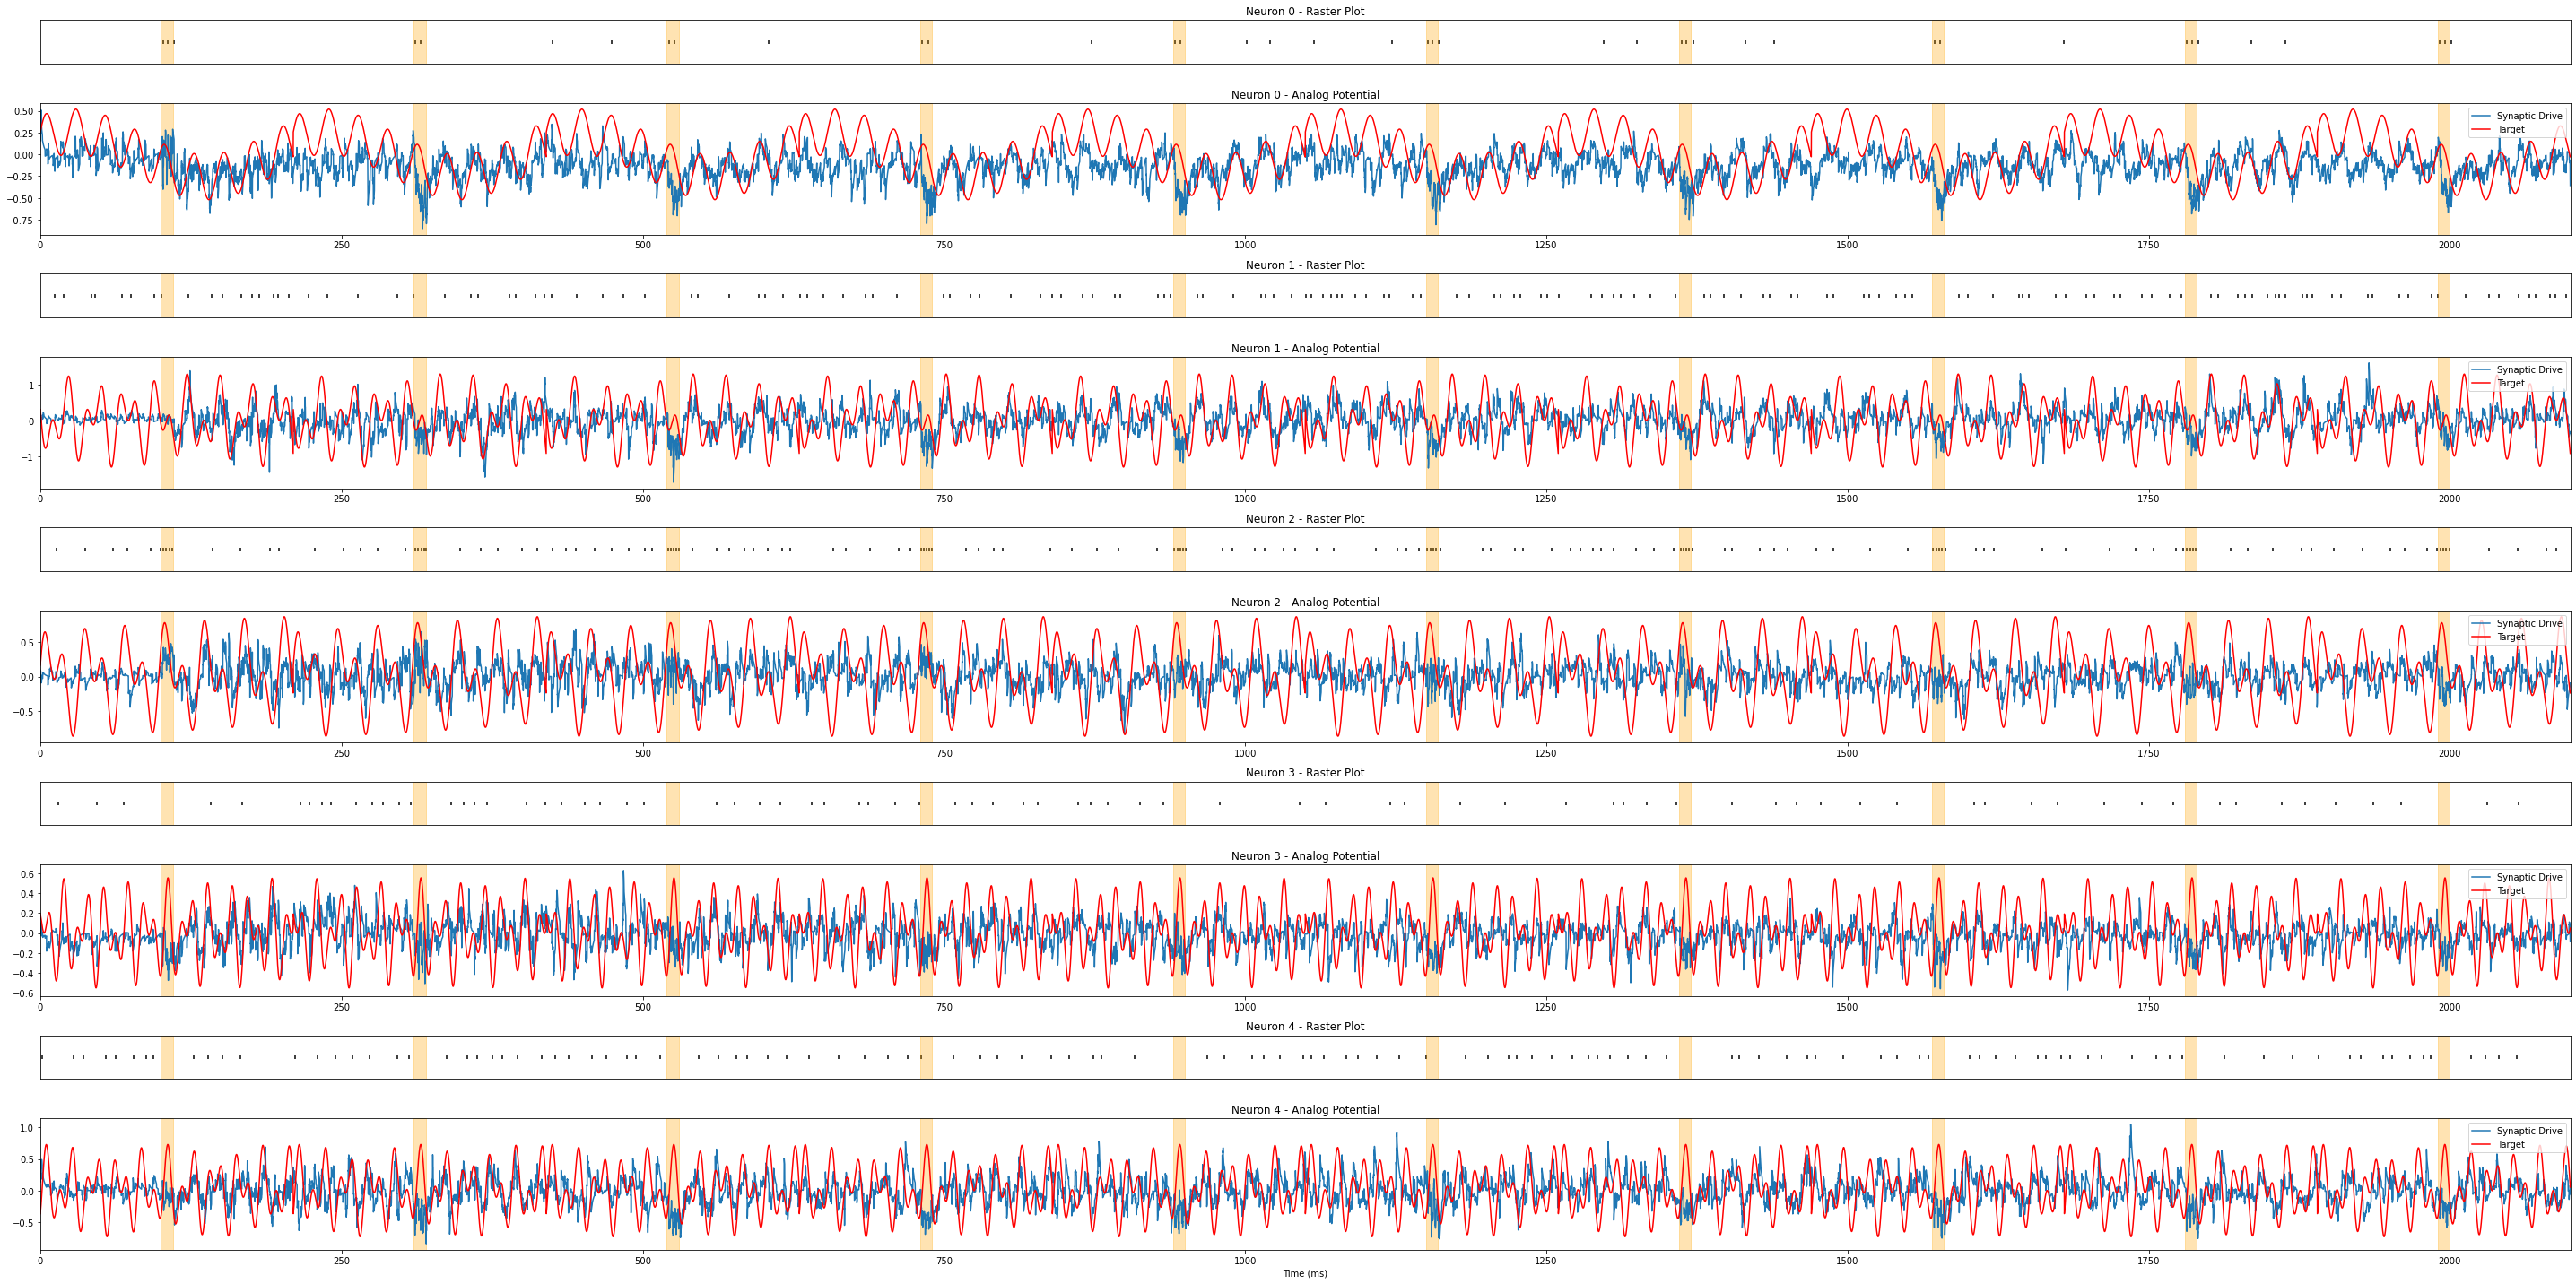

In [370]:
plot_neural_activity(spikes_over_time, u_over_time, utarg_over_time, dt, neurons_to_plot, time_param, nloop)

In [360]:
# Testing phase
# Reinitialize initial conditions
x0 = 2 * np.pi * np.random.rand(N)
r0 = np.zeros(N)
z0 = np.zeros(N)

# Set up parameters for testing
net_param = [x0, r0, b, stim]
time_param = [stim_on, stim_off, test_time]

# Run the testing process
utest = run_test(M, net_param, time_param, dt)

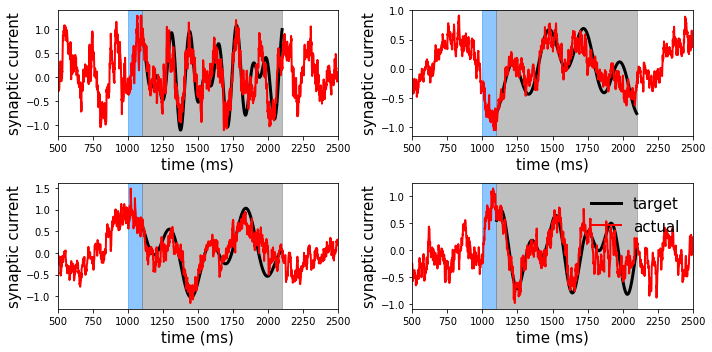

In [361]:
# Plotting the results
# Create a time vector for plotting
tvec = np.arange(dt, test_time + dt, dt)

# Set up the plot
plt.figure(figsize=(10, 5))
nrow, ncol = 2, 2  # Number of rows and columns in the subplot

# Loop over each subplot
for i in range(nrow * ncol):
    plt.subplot(2, 2, i + 1)
    plt.axvspan(10 * stim_on, 10 * stim_off, alpha=0.5, color="dodgerblue")
    plt.axvspan(10 * stim_off, 10 * train_time, alpha=0.5, color="gray")

    # Plot target and actual patterns during the stimulation period
    ton = int(stim_off / dt)
    toff = int(train_time / dt)
    plt.plot(tvec[ton:toff] * 10, utarg[ton:toff, i], linewidth=3, color="black", label="target")
    plt.plot(tvec * 10, utest[:, i], linewidth=2, color="red", alpha=1, label="actual")

    # Set plot limits and labels
    plt.xlim([500, 2500])
    plt.xlabel("time (ms)", fontsize=15)
    plt.ylabel("synaptic current", fontsize=15)

    # Add legend to the last subplot
    if i == 3:
        plt.legend(loc=1, frameon=False, fontsize=15)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()